# Tokenizacion #
Para el primer paso, tokenizaremos los titulos de youtobe.

In [2]:
import nltk
import pandas as pd


nltk.download('punkt')

# Cargar el archivo CSV con las primeras 40,000 filas
data = pd.read_csv('../data/MXvideos.csv', nrows=40000, encoding='utf-8',
                       on_bad_lines='skip',
                       encoding_errors='replace')


# Extraer la columna de títulos
allTitles = data['title']

tokesReview ={}#arreglo de tokens

for iterador, review in enumerate(allTitles):
    
    # Tokenizar la reseña
    tokens = nltk.word_tokenize(review)
    video_id = data.iloc[iterador]['video_id']

    # Asignar los tokens a su 'review_id' correspondiente
    tokesReview[video_id] = tokens

    # Incrementamos el iterador
    iterador += 1


[nltk_data] Downloading package punkt to C:\Users\MARTHA ISABEL
[nltk_data]     VILLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Se analiza la similitud con el titulo deseado #

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Función para encontrar los títulos más similares a un título dado
def find_similar_titles(input_title, allTitles, top_n=10):
    # Se utiliza TF-IDF para vectorizar los títulos
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(allTitles)

    # Transformar el título ingresado utilizando el mismo modelo de vectorización
    input_title_tfidf = vectorizer.transform([input_title])

    # Calcular la similitud de coseno entre el título proporcionado y los demás
    cosine_similarities = cosine_similarity(input_title_tfidf, tfidf_matrix).flatten()

    # Obtener los índices de los títulos con mayor similitud
    top_n_similar_indices = cosine_similarities.argsort()[-(top_n+1):-1][::-1]

    # Devolver los títulos más similares
    similar_titles = allTitles.iloc[top_n_similar_indices]
    return similar_titles

# Título que deseas comparar
input_title = "Estados Unidos"  # Agrega el deseado

# Extraer la columna de títulos
allTitlesUniq = data['title'].dropna().drop_duplicates()

# Buscar y mostrar los 10 títulos más similares
similar_titles = find_similar_titles(input_title, allTitlesUniq)

print(similar_titles)


30234          Vídeos Del ATAQUE de Estados Unidos A Siria
22137        COMIDA MEXICANA  EN ESTADOS UNIDOS | EL GUZII
28535              RED+ | Estados Unidos bombardea a Siria
4891                Truena Tv Azteca en los Estados Unidos
1641     Daniel El Travieso - Regresó De Los Estados Un...
3952     Los 6 Autos mas Importantes de Estados Unidos ...
28724    Rusia responde a ataque de Estados Unidos a Siria
15581         ¿Podría MÉXICO luchar contra ESTADOS UNIDOS?
2781     Información De La Luna 27 De Noviembre De 2017...
16306    Detrás de la Razón - ¿Rusia contra Estados Uni...
Name: title, dtype: object


# nube de palabras #
Aqui se genera una nube de palabras con base en la cantidad de likes


[nltk_data] Downloading package stopwords to C:\Users\MARTHA ISABEL
[nltk_data]     VILLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


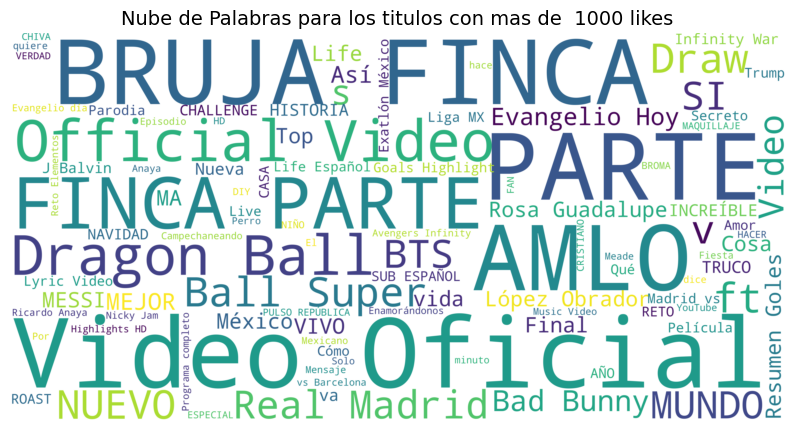

In [5]:
from wordcloud import WordCloud # Importar las bibliotecas necesarias
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('stopwords')

# Eliminamos los stopwords en inglés
stop_words = set(stopwords.words('spanish'))  


#creamos un nuevo diccionario que almacena los tokens sin stopwords
tokensTitle_clean={}

# Iterar sobre cada review_id y su lista de tokens
for review_id, tokens in tokesReview.items():
    # Filtrar las stopwords de los tokens para cada reseña
    tokens_clean = [word for word in tokens if word.lower() not in stop_words]
    
    # Almacenar los tokens limpios en el nuevo diccionario con el mismo review_id
    tokensTitle_clean[review_id] = tokens_clean



# Definir la función word_cloud_rating
def word_cloud_rating(data, likes, tokens_clean):

    # Filtrar las reseñas que corresponden a un valor específico de estrellas
    subset_data = data[data['likes'] >= likes]
        
    # Filtrar los tokens correspondientes a cada video_id en el subset_data
    filtered_tokens = []


    # Filtrar los tokens correspondientes a cada video_id en el subset_data
    filtered_tokens = [tokens_clean[row['video_id']] for _, row in subset_data.iterrows()]



    # Unir todas los titulos en un solo texto
    word_cloud_text = ' '.join([' '.join(tokens) for tokens in filtered_tokens])
    
    # Generar la nube de palabras
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", scale=10, width=800, height=400).generate(word_cloud_text)
    
    # Visualizar la nube de palabras
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f'Nube de Palabras para los titulos con mas de  {likes} likes', fontsize=14)
    plt.show()

# Llamar a la función para los titulos
word_cloud_rating(data, 1000, tokensTitle_clean)

# 5 palabras mas repetidas segun un rango de likes #

Esta grafica muestra las palabras que mas se repiten en 2 rangos de likes [0-2000]  -  [2001-10000]  

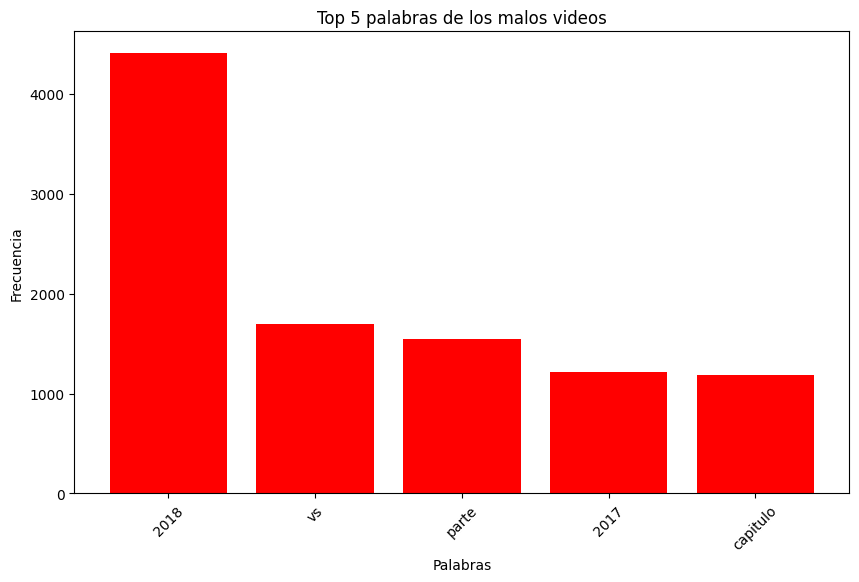

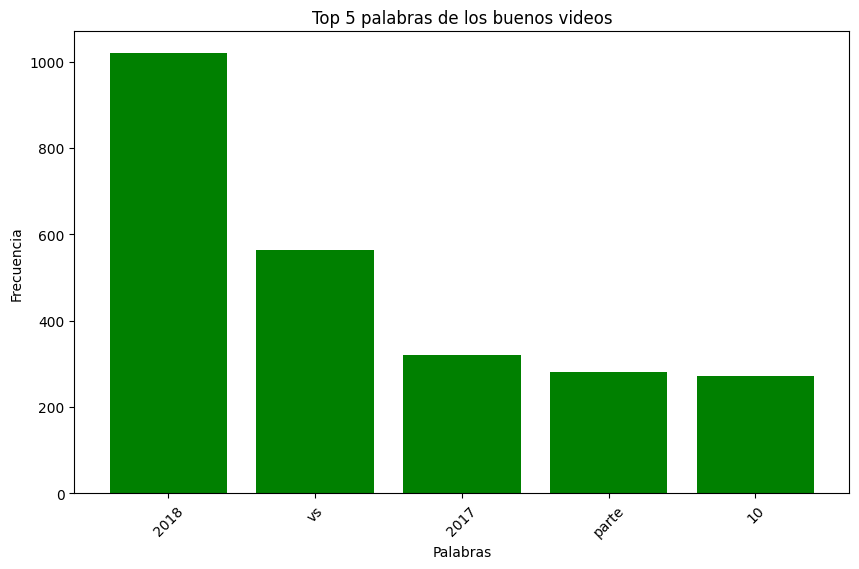

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pandas as pd

data['title_clean'] = data['video_id'].apply(lambda video_id: ' '.join(tokensTitle_clean[video_id]))

# Definir las reseñas malas y buenas (asumiendo que ya tienes la columna 'text_clean')
negative_titles = data[(data['likes'] >= 0) & (data['likes'] <= 2000)]['title_clean']
positive_titles = data[(data['likes'] >= 2001) & (data['likes'] <= 10000)]['title_clean']

# Crear el vectorizador para contar palabras, sin filtrar stopwords
vectorizer_neg = CountVectorizer(max_features=5)
vectorizer_pos = CountVectorizer(max_features=5)

# Transformar los textos de malas y buenas reseñas en matrices de frecuencias de palabras
X_neg = vectorizer_neg.fit_transform(negative_titles)
X_pos = vectorizer_pos.fit_transform(positive_titles)

# Extraer las palabras y sus frecuencias
neg_word_freq = X_neg.toarray().sum(axis=0)  # Sumar las frecuencias de las palabras para todas las malas reseñas
pos_word_freq = X_pos.toarray().sum(axis=0)  # Sumar las frecuencias de las palabras para todas las buenas reseñas

neg_words = vectorizer_neg.get_feature_names_out()
pos_words = vectorizer_pos.get_feature_names_out()

# Crear DataFrames con los resultados para facilitar la creación del gráfico
df_neg = pd.DataFrame({'word': neg_words, 'frequency': neg_word_freq}).sort_values(by='frequency', ascending=False)
df_pos = pd.DataFrame({'word': pos_words, 'frequency': pos_word_freq}).sort_values(by='frequency', ascending=False)

# Graficar las 5 palabras más frecuentes en malas y buenas reseñas

# Graficar malos videos
plt.figure(figsize=(10, 6))
plt.bar(df_neg['word'], df_neg['frequency'], color='red')
plt.title('Top 5 palabras de los malos videos')
plt.xticks(rotation=45)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

# Graficar los buenos videos
plt.figure(figsize=(10, 6))
plt.bar(df_pos['word'], df_pos['frequency'], color='green')
plt.title('Top 5 palabras de los buenos videos')
plt.xticks(rotation=45)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()
